In [103]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

c:\Users\Usuario\Documents\TP1_RossmannStoreSales\venv\lib\site-packages\tensorflow\python\client\session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [104]:
import pandas as pd
import numpy as np
import datetime
from pandas_summary import DataFrameSummary

In [105]:
from tensorflow.keras.utils import to_categorical

In [106]:
df = pd.read_feather('preprocessed_dfs/train_normalized_data.fth')
df_test = pd.read_feather('preprocessed_dfs/test_normalized_data.fth')

In [107]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen', 'Promo2Weeks', 
            'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', 
            'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_bool_fw', 'StateHoliday_bool_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw']


contin_vars = ['CompetitionDistance', 
   'Max_TemperatureC',
   # 'Mean_TemperatureC',
   # 'Min_TemperatureC',
   'Precipitationmm',
   # 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   # 'Mean_Wind_SpeedKm_h', 'CloudCover',
   #'trend', 'trend_DE',
   # 'AfterStateHoliday', 'BeforeStateHoliday_bool', 'Promo', 'SchoolHoliday', 'StateHoliday_bool'
   ]

uniques = DataFrameSummary(df[cat_vars]).summary().loc[['uniques']]
uniques.T

,uniques
Store,1115
DayOfWeek,7
Year,3
Month,12
Day,31
StateHoliday,4
CompetitionMonthsOpen,25
Promo2Weeks,26
StoreType,4
Assortment,3


### Entity Embeddings

Dado que las redes neuronales trabajan en el conjunto de los números reales, representar categorías con un entero no suele funcionar bien. Para solucionar esto se puede usar one-hot encoding o entity embeddings. One-hot encoding tiene dos problemas que no tiene entity embeddings:

1. Si las categorías son muchas se consume mucho poder computacional para entrenar el modelo. Por ejemplo, hay 1115 tiendas en este problema.
2. La red trata los distintos one-hot vectors como entidades indepedientes. Es decir, no aprende nada sobre la interrelación entre categorías. Por ejemplo, quizás hay tiendas que suelen tener ventas parecidas y eso puede usarse para mejorar la predicción.

Entity embedding es una representación vectorial de alguna entidad (en este caso de categorías). Para esta aplicación, la idea detrás de Entity Embeddings es representar variables categoricas (discretas) en un espacio continuo. Es decir, que el modelo pueda aprender una representación contínua dadas ciertas categorías. La representación se dará a través de vectores en un espacio multidimensional (la dimensión es a lo sumo igual a la cantidad de categorías), de forma que la cercanía entre vectores denota una mayor dependencia entre esas categorías. La clave es que la red aprende a representar la continuidad intrínseca del problema.

Matemáticamente, para N categorías se entra con un one-hot vector de Nx1 o con un índice i a una matriz de M*N, donde M es la dimensión del espacio donde se representan las categorías. La salida de esta operación es la columna i-ésima de la matriz. Como lo que se entrena es la matriz, el modelo entrena la representación de las categorías en un espacio M-dimensional.

https://arxiv.org/pdf/1604.06737.pdf

Dimensión de los Entity Embeddings

In [108]:
cat_var_dict = {'Store': 10, 'DayOfWeek': 6, 'Year': 2, 'Month': 6,
'Day': 5, 'StateHoliday': 4, 'CompetitionMonthsOpen': 5,
'Promo2Weeks': 5, 'StoreType': 2, 'Assortment': 3, 'PromoInterval': 3,
'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'State': 6,
'Week': 10, 'Events': 4, 'Promo_fw': 2,
'Promo_bw': 2, 'StateHoliday_bool_fw': 2,
'StateHoliday_bool_bw': 2, 'SchoolHoliday_fw': 2,
'SchoolHoliday_bw': 2
}

for v in cat_vars:
    uniques_ = df[v].unique()
    uniques_.sort()
    print(v, cat_var_dict[v], len(uniques_), uniques_)

Store 10 1115 [   0    1    2 ... 1112 1113 1114]
DayOfWeek 6 7 [0 1 2 3 4 5 6]
Year 2 3 [0 1 2]
Month 6 12 [ 0  1  2  3  4  5  6  7  8  9 10 11]
Day 5 31 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
StateHoliday 4 4 [0 1 2 3]
CompetitionMonthsOpen 5 25 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Promo2Weeks 5 26 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
StoreType 2 4 [0 1 2 3]
Assortment 3 3 [0 1 2]
PromoInterval 3 4 [0 1 2 3]
CompetitionOpenSinceYear 4 21 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Promo2SinceYear 4 8 [0 1 2 3 4 5 6 7]
State 6 12 [ 0  1  2  3  4  5  6  7  8  9 10 11]
Week 10 52 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51]
Events 4 22 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Promo_fw 2 

## Modelo

In [109]:
add_customers = True
log_output = True
output_activation = 'linear'

In [110]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, BatchNormalization, Activation, LeakyReLU, Dropout
from tensorflow.keras.regularizers import l2

In [111]:
def get_cat_vars_model(cat_vars, uniques, cat_var_dict):
    cat_vars_embed_outs = []
    cat_var_inputs = []
    for cat_var in cat_vars:
        cat_var_in = Input(shape=(1,), name=f"{cat_var}_input")
        cat_var_inputs.append(cat_var_in)
        embed_out = Embedding(uniques[cat_var][0], cat_var_dict[cat_var], name=f'{cat_var}_Embed')(cat_var_in)
        flatten_out = Flatten(name=f"{cat_var}_flat")(embed_out)
        cat_vars_embed_outs.append(flatten_out)
    return cat_var_inputs, cat_vars_embed_outs

def get_cont_vars_input(contin_vars, dense_layer=False):
    cont_vars_inputs = []
    cont_vars_outputs = []
    for cont_var in contin_vars:
        cont_var_in = Input(shape=(1,), name=f"{cont_var}_input")
        cont_vars_inputs.append(cont_var_in)
        if dense_layer:
            cont_var_out = Dense(1, name=f"{cont_var}_input", activation = 'linear')(cont_var_in)
            cont_vars_outputs.append(cont_var_out)
        else:
            cont_vars_outputs.append(cont_var_in)
    return cont_vars_inputs, cont_vars_outputs

In [112]:
cat_var_inputs, cat_vars_embed_outs = get_cat_vars_model(cat_vars, uniques, cat_var_dict)
cont_vars_inputs,  cont_vars_outs= get_cont_vars_input(contin_vars)

In [113]:
# Descomentar para ver resultados
print(cat_vars_embed_outs)
print(cat_var_inputs)
print(cont_vars_inputs)
print(cont_vars_outs)

[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'Store_flat')>, <KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'DayOfWeek_flat')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'Year_flat')>, <KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'Month_flat')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Day_flat')>, <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'StateHoliday_flat')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'CompetitionMonthsOpen_flat')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Promo2Weeks_flat')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'StoreType_flat')>, <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'Assortment_flat')>, <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'PromoInterval_flat')>, <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'CompetitionOpenSinceYear_flat'

In [114]:
first_hidden_units = 1000
second_hidden_units = 500
l2_lambda = 0
merged = Concatenate(name='All_Concatenate')(cat_vars_embed_outs + cont_vars_inputs)
x = Dense(first_hidden_units, kernel_initializer="uniform", kernel_regularizer=l2(l2_lambda))(merged)
# x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = LeakyReLU()(x)
x = Dense(second_hidden_units, kernel_initializer="uniform", kernel_regularizer=l2(l2_lambda))(x)
# x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = LeakyReLU()(x)

output_1 = Dense(1, name='Sales', activation=output_activation)(x)
output_2 = Dense(1, name='Customers', activation=output_activation)(x)

In [115]:
if add_customers:
    model = Model(cat_var_inputs + cont_vars_inputs, [output_1, output_2])
else: 
    model = Model(cat_var_inputs + cont_vars_inputs, [output_1])

In [116]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Store_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 DayOfWeek_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 Year_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Month_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                            

In [117]:
model.save_weights('model/initial_weights.hdf5')

In [118]:
df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]
print(f'Cantidad en val: {len(df_val)}, porcentaje: {len(df_train)/(len(df_train) + len(df_val))}')

Cantidad en val: 30188, porcentaje: 0.9642465458145908


In [119]:
stores_mean = {}
for store, g_df in df_train.groupby('Store'):
    stores_mean[store] = g_df[g_df['Sales'] > 0]['Sales'].mean()

df_train.loc[:, 'mean_by_store'] = df_train['Store'].apply(stores_mean.get)
df_val.loc[:, 'mean_by_store'] = df_val['Store'].apply(stores_mean.get)

df_train.loc[:, 'Sales_store'] = df_train['Sales'] - df_train['mean_by_store']
df_val.loc[:, 'Sales_store'] = df_val['Sales'] - df_val['mean_by_store']

C:\Users\Usuario\AppData\Local\Temp\ipykernel_13572\817407575.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, 'mean_by_store'] = df_train['Store'].apply(stores_mean.get)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_13572\817407575.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.loc[:, 'mean_by_store'] = df_val['Store'].apply(stores_mean.get)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_13572\817407575.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [120]:
from tensorflow.keras import backend as K

def rmspe(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_true - y_pred)/y_true)))
def get_metric(df, sales_):
    return np.sqrt((((df['Sales'] - sales_)/df['Sales'])**2).mean())
    
get_metric(df_val, df_val['mean_by_store'])

0.3071746085338871

Train

In [121]:
all_vars = cat_vars + contin_vars
X_train = np.hsplit(df_train[all_vars].values, len(all_vars))
X_val = np.hsplit(df_val[all_vars].values, len(all_vars))
X_test = np.hsplit(df_test[all_vars].values, len(all_vars))

In [122]:
# Anotaciones

if add_customers:
    y_out_columns = ['Sales', 'Customers']
else:
    y_out_columns = ['Sales_store']
    
if log_output:
    # Escala logaritmica
    max_log_y = np.max(np.log(df[y_out_columns])).values
    y_train = np.log(df_train[y_out_columns].values)/max_log_y
    y_val = np.log(df_val[y_out_columns].values)/max_log_y
else:
    # Normalización
    y_mean = df_train[y_out_columns].mean().values
    y_std = df_train[y_out_columns].std().values
    y_train = (df_train[y_out_columns].values - y_mean)/y_std
    y_val = (df_val[y_out_columns].values - y_mean)/y_std
    y_max = df_train[y_out_columns].max().values
    y_train = df_train[y_out_columns].values/y_max
    y_val = df_val[y_out_columns].values/y_max
y_train = np.hsplit(y_train, y_train.shape[1])
y_val = np.hsplit(y_val, y_val.shape[1])

c:\Users\Usuario\Documents\TP1_RossmannStoreSales\venv\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [123]:
lr = 0.001
model.compile(optimizer=Adam(learning_rate=lr), metrics=['mse', rmspe], loss='mse')

In [124]:
if add_customers:
    checkpoint = ModelCheckpoint('bestmodel.hdf5', monitor='val_Sales_mse', verbose=1, save_best_only=True)
else:
    checkpoint = ModelCheckpoint('bestmodel.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

In [125]:
epochs = 10
batch_size = 256
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),  epochs=epochs, batch_size=batch_size, callbacks=[checkpoint], verbose=2)

Epoch 1/10

Epoch 1: val_Sales_mse improved from inf to 0.00027, saving model to bestmodel.hdf5
3181/3181 - 63s - loss: 0.0024 - Sales_loss: 0.0012 - Customers_loss: 0.0012 - Sales_mse: 0.0012 - Sales_rmspe: 0.0246 - Customers_mse: 0.0012 - Customers_rmspe: 0.0281 - val_loss: 4.5299e-04 - val_Sales_loss: 2.7311e-04 - val_Customers_loss: 1.7988e-04 - val_Sales_mse: 2.7311e-04 - val_Sales_rmspe: 0.0195 - val_Customers_mse: 1.7988e-04 - val_Customers_rmspe: 0.0182 - 63s/epoch - 20ms/step
Epoch 2/10

Epoch 2: val_Sales_mse improved from 0.00027 to 0.00018, saving model to bestmodel.hdf5
3181/3181 - 61s - loss: 3.2417e-04 - Sales_loss: 1.6334e-04 - Customers_loss: 1.6082e-04 - Sales_mse: 1.6334e-04 - Sales_rmspe: 0.0156 - Customers_mse: 1.6082e-04 - Customers_rmspe: 0.0176 - val_loss: 3.9579e-04 - val_Sales_loss: 1.8356e-04 - val_Customers_loss: 2.1223e-04 - val_Sales_mse: 1.8356e-04 - val_Sales_rmspe: 0.0160 - val_Customers_mse: 2.1223e-04 - val_Customers_rmspe: 0.0195 - 61s/epoch - 19ms/s

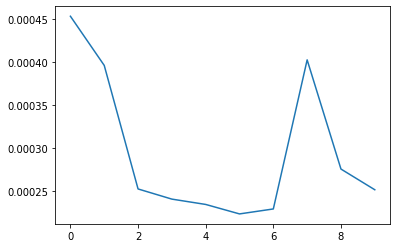

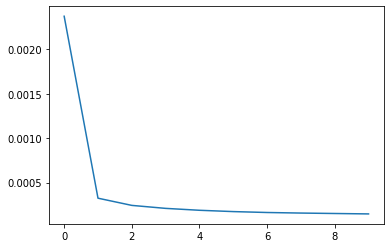

In [126]:
from matplotlib import pyplot as plt

plt.plot(history.history['val_loss'])
# plt.plot(history.history['val_Customers_mse'])
# plt.plot(history.history['val_Sales_mse'])
plt.show()
plt.plot(history.history['loss'])
# plt.plot(history.history['Customers_mse'])
# plt.plot(history.history['Sales_mse'])

Evaluate


In [127]:
model.load_weights('bestmodel.hdf5')
model.evaluate(X_val, y_val)

944/944 [==============================] - 4s 4ms/step - loss: 2.4030e-04 - Sales_loss: 1.1650e-04 - Customers_loss: 1.2380e-04 - Sales_mse: 1.1650e-04 - Sales_rmspe: 0.0128 - Customers_mse: 1.2380e-04 - Customers_rmspe: 0.0149


[0.00024030070926528424,
 0.00011649873340502381,
 0.0001238020195160061,
 0.00011649873340502381,
 0.012847675010561943,
 0.0001238020195160061,
 0.014913570135831833]

In [128]:
model.evaluate(X_val, y_val)

944/944 [==============================] - 4s 4ms/step - loss: 2.4030e-04 - Sales_loss: 1.1650e-04 - Customers_loss: 1.2380e-04 - Sales_mse: 1.1650e-04 - Sales_rmspe: 0.0128 - Customers_mse: 1.2380e-04 - Customers_rmspe: 0.0149


[0.00024030070926528424,
 0.00011649873340502381,
 0.0001238020195160061,
 0.00011649873340502381,
 0.012847675010561943,
 0.0001238020195160061,
 0.014913570135831833]

Predict

In [129]:
if log_output:
    if add_customers:
        y_pred = np.exp(model.predict(X_val, verbose=1)[0][:, 0]*max_log_y[0])
        y_pred_test = np.exp(model.predict(X_test, verbose=1)[0][:, 0]*max_log_y[0])
    else:
        y_pred = np.exp(model.predict(X_val, verbose=1)*max_log_y)[:,0]
        y_pred_test = np.exp(model.predict(X_test, verbose=1)*max_log_y)[:,0]
else:
    if add_customers:
        y_pred = (model.predict(X_val, verbose=1)[0]*y_std[0] + y_mean[0])[:,0]
        y_pred_test = (model.predict(X_test, verbose=1)[0]*y_std[0] + y_mean[0])[:,0]
    else:
#         y_pred = model.predict(X_val, verbose=1)[:,0]*y_std + y_mean
#         y_pred_test = model.predict(X_test, verbose=1)[:,0]*y_std + y_mean
        y_pred = model.predict(X_val, verbose=1)[:,0]*y_max
        y_pred_test = model.predict(X_test, verbose=1)[:,0]*y_max
y_pred_test[df_test['Open'] == 0] = 0

1284/1284 [==============================] - 8s 6ms/step


## Métrica

Mean Square Error -> es menor en tanto la suma de las predicciones es igual a la suma de los valores reales. Es decir que genera un predicción insesgada. La magnitud de MSE depende de las magnitudes y la unidad no es la misma que la de las observaciones/predicciones.

Root Mean Square Error -> se toma la raíiz cuadrada del MSE para tener la misma unidad que la observaciones. Así se tiene una idea de la distancia cuadrática media entre la predicción y la realidad en las unidades correctas. Como penaliza los errores grandes más que el MAE, también es más sensible a outliers.

Root Mean Square Percentage Error -> la diferencia con RMSE es que se suman los cuadrados de los errores porcentuales. Entonces nos da una idea del error porcentual que tiene una medición. La ventaja es que al ser porcentual, es una buena medida de qué tan buenas son las predicciones en relación a las observaciones.

Mean Absolute Error -> es menor en tanto las predicciones queden en torno a la mediana. Por lo tanto, tiende a tener sesgo.

https://towardsdatascience.com/forecast-kpi-rmse-mae-mape-bias-cdc5703d242d
https://s2.smu.edu/tfomby/eco5385_eco6380/lecture/Scoring%20Measures%20for%20Prediction%20Problems.pdf



La métrica de la competencia es RMSPE ya que es de interés que las predicciones estén lo más cerca posible de las ventas reales porcentualmente (no es lo mismo 100$ de error en 1000$ de ventas que en 20000$)

In [138]:
np.sqrt((((df_val['Sales'].values - y_pred) / df_val['Sales'].values)**2).sum()/len(y_pred))

0.11944965401989534

In [139]:
# bias
np.sum((df_val['Sales'].values - y_pred))/len(y_pred)

101.7392712738777

## Submission

In [140]:
sample_csv = pd.read_csv('data/sample_submission.csv')

In [141]:
sample_csv['Sales'] = y_pred_test
sample_csv.head()

sample_csv.to_csv(f'submissions/submission_.csv', index=0)

## Análisis de Embeddings

In [142]:
model.load_weights('bestmodel.hdf5')

In [136]:
from sklearn.manifold import TSNE

In [137]:
cat_vars

['Store',
 'DayOfWeek',
 'Year',
 'Month',
 'Day',
 'StateHoliday',
 'CompetitionMonthsOpen',
 'Promo2Weeks',
 'StoreType',
 'Assortment',
 'PromoInterval',
 'CompetitionOpenSinceYear',
 'Promo2SinceYear',
 'State',
 'Week',
 'Events',
 'Promo_fw',
 'Promo_bw',
 'StateHoliday_bool_fw',
 'StateHoliday_bool_bw',
 'SchoolHoliday_fw',
 'SchoolHoliday_bw']

In [ ]:

tsne = TSNE(n_components=2, random_state=1, learning_rate=10, n_iter=10000)
NAMES = {
    "DayOfWeek": ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun'],
    "Month": list(range(1,13)),
    "Year": ["2013", "2014", "2015"],
    "State": ["BE", "BW", "BY", "HB,NI", "HE", "HH", "NW", "RP", "SH", "SN", "ST", "TH"],
    "StateHoliday": ["a", "b", "c", "0"],
    "StoreType": ["a", "b", "c", "d"],
}

for var in cat_vars:
    embedding = var + "_Embed"
    matrix = model.get_layer(embedding).get_weights()[0]

    Y = tsne.fit_transform(matrix)
    names = NAMES.get(var)

    plt.figure(figsize=(8,8))
    plt.scatter(-Y[:, 0], -Y[:, 1])
    if names is not None:
        for i, txt in enumerate(names):
            plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')
    plt.savefig(f"embeddings/{embedding}.svg")
